# Validation
to make every wine accessible, we train the model again on the full dataset

In [1]:
from IPython.display import display, clear_output
import os
import seaborn as sns
import numpy as np
from importlib import reload

import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from wine_and_cheese_utils import WineList, df_columns, regexp_tokenizer

%matplotlib inline

import warnings
    
warnings.filterwarnings("ignore")

## Import the data in a WineList object

In [2]:
wl = WineList(file='cleaned')
# create and store the TaggedDocument list
wl.get_tagged_data()
# import (or retrain) the Doc2Vec model
wl.get_doc2vec_model()

loading tagged_data_set.pkl
loading Doc2Vec model from doc2vec.model


In [3]:
# we evaluate the model on regions
column_name = 'region_1'
# count the number of wines in the DataFrame for each region
wl.get_column_cnt_list(column_name)

(1, 10000)

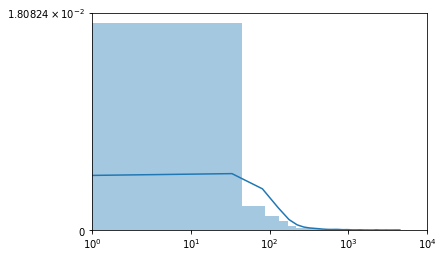

In [4]:
# distribution of wine occurences
sns.distplot([x['count'] for x in wl.column_cnt[column_name]],bins=100)
plt.xscale('symlog')
plt.yscale('symlog')
plt.xlim([1,10000])

In [18]:
# get the list of regions with more than n_min wines in the DataFrame
top_regions = wl.get_top_keys(column_name,n_min=50)
top_region_list = [x for x in top_regions]

In [19]:
# Evaluate how close (cosine) 2 wines from the same region
within_region_cosines = []
random_cosines = []
for n in range(0,3000):
    region = random.choice(top_region_list)
    wines = wl.df[wl.df.region_1==region['name']]
    if len(wines)>2:
        d1,d2 = [row.Index for row in wines.sample(n=2).itertuples()]
        within_region_cosines.append(wl.model.docvecs.similarity(d1,d2))
        d1,d2 = [row.Index for row in wl.df.sample(n=2).itertuples()]
        random_cosines.append(wl.model.docvecs.similarity(d1,d2))

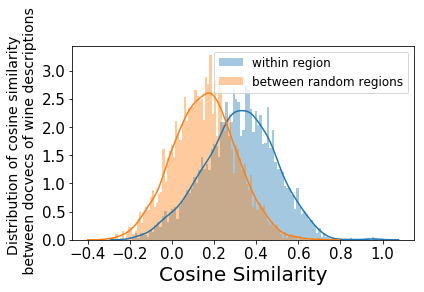

In [41]:
sns.distplot(within_region_cosines,bins=100)
sns.distplot(random_cosines,bins=100)
# plt.xlim([0.95,1])
plt.xlabel('Cosine Similarity', fontsize=20)
plt.xticks(fontsize=15)
# plt.title('Wines from the same region have higher \n cosine similarity than wine from random regions', fontsize=14)
plt.ylabel('Distribution of cosine similarity \n between docvecs of wine descriptions', fontsize=14)
plt.yticks(fontsize=15)
plt.legend(['within region','between random regions'], fontsize=12)
# plt.yscale('symlog')
plt.tight_layout()
plt.savefig('figures/within_across_regions.pdf')
plt.savefig('figures/within_across_regions.png')

## mean feature vector for each 'top' region
for each region that has more than n_min wines, we compute the mean feature vector

In [ ]:
# set a threshold for the cosine similarity
cosine_similarity_threshold = 0.9999
# initialize a dictionary to store the mean vector for each region
mean_vects_dict = dict.fromkeys([x['name'] for x in top_region_list],np.zeros(40,))
# for every region in the list
for region in top_region_list:
    # get the rows for wines of that region
    region_df = wl.df[wl.df.region_1==region['name']]
    # shuffle the filtered DataFrame wines
    region_df = region_df.sample(frac=1)
    # initialize a counter
    cnt=0
    # and a "previous vector"
    prev_vec = np.ones(40,).reshape(1, -1)
    keepgoing = True

    for row in region_df.itertuples():
        if keepgoing:
            cnt+=1
            # infer the feature vector
            new_vec = wl.model.infer_vector(wl.tokenize(row.description)).reshape(1, -1)
            # update the mean vector
            mean_vects_dict[region['name']] = ((cnt-1)*mean_vects_dict[region['name']]+new_vec)/cnt
            # update the previous vector
            prev_vec = mean_vects_dict[region['name']]
            # test if we reached the threshold for the convergence of the mean vector
            keepgoing = cosine_similarity(prev_vec,mean_vects_dict[region['name']])<cosine_similarity_threshold        
        else:
            break

In [38]:
# concatenate all the mean vectors into an array
cat_mean_vects = np.concatenate(list(mean_vects_dict.values()),axis=0)

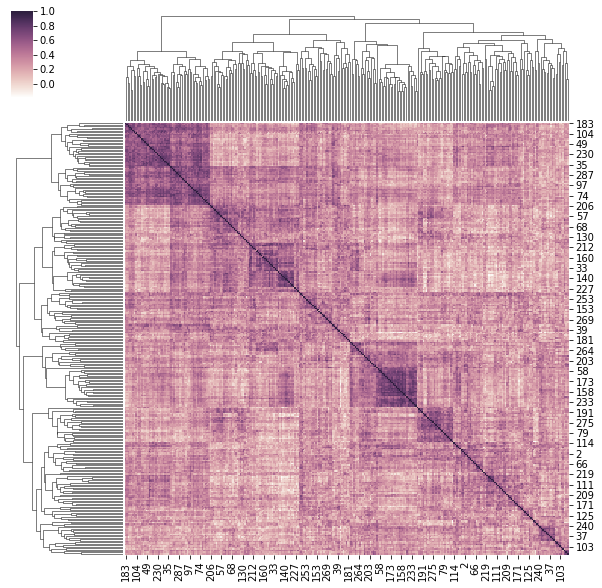

In [126]:
# apply clustermap
cg = sns.clustermap(sim_mat,cmap=sns.cubehelix_palette(light=1, as_cmap=True))

In [ ]:
[top_regions[idx]['name'] for idx in cg.dendrogram_col.reordered_ind]

In [122]:
# pick a random region and get its vector
region = random.choice(top_regions)
mean_vect = np.array(mean_vects_dict[region['name']])
print(region['name'])
# find the most similar docsvec for its mean vector
similar_docs = wl.model.docvecs.most_similar(mean_vect,topn=30)
[print(doc[0],wl.df.loc[doc[0]].region_1) for doc in similar_docs]
print(wl.df.loc[similar_docs[0][0]].description)

Columbia Valley (WA)
6462 Columbia Valley (WA)
16191 Yakima Valley
37221 Columbia Valley (WA)
78834 Walla Walla Valley (WA)
95204 Columbia Valley (WA)
98579 Red Mountain
96325 Columbia Valley (WA)
46076 Willamette Valley
56987 Columbia Valley (WA)
101921 Napa Valley
122567 Columbia Valley (WA)
59913 Snipes Mountain
59296 Red Mountain
1796 Red Mountain
38155 Columbia Valley (WA)
83211 Walla Walla Valley (WA)
29968 McMinnville
51940 Columbia Valley (WA)
22627 Horse Heaven Hills
74551 Columbia Valley (WA)
128968 Columbia Valley (WA)
43961 Horse Heaven Hills
98738 Yorkville Highlands
76582 Red Mountain
100307 Washington
53432 Walla Walla Valley (WA)
82650 Willamette Valley
91078 Columbia Gorge (OR)
1424 Columbia Valley (WA)
125056 Columbia Valley (WA)
Mostly Syrah, with some Cabernet Sauvignon, this is a succulent rosé with a marvelous mouthfeel. Texture and length are its main charms, with nuanced notes of rose petal, hibiscus, watermelon and pie cherry. The vineyard sources are Klipsun, 

In [130]:
similar_docs[0]

(6462, 0.8540639877319336)

'Mostly Syrah, with some Cabernet Sauvignon, this is a succulent rosé with a marvelous mouthfeel. Texture and length are its main charms, with nuanced notes of rose petal, hibiscus, watermelon and pie cherry. The vineyard sources are Klipsun, Boushey and Ciel du Cheval.'

[2, 39133, 109241, 28318, 55873, 110969, 35047, 916, 75884, 62093]

In [114]:
column_name = 'region_1'
cnt = -1
that_list = []
for key in list(set(wl.df[column_name])):
    that_list.append({'name':key,'count':len(wl.df[wl.df[column_name]==key])})


In [35]:
d1 = wl.tagged_data[0].tags[0]
print(d1)

2


In [38]:
d2 = wl.tagged_data[1].tags[0]
print(d2)

3


In [59]:
wl.model.docvecs.similarity(d1,d2)


0.17394547

In [60]:
desc1 = wl.tagged_data[0].words
v1 = wl.model.infer_vector(desc1)

desc2 = wl.tagged_data[1].words
v2 = wl.model.infer_vector(desc1)

cosine_similarity(v1.reshape(1, -1),v2.reshape(1, -1))

array([[0.9872115]], dtype=float32)

0.25554273

In [18]:
d1

89109

In [19]:
d2

113153

In [22]:
desc1 = wl.tokenize(wl.df[wl.df.index==d1].description.values[0])
print(desc1)
v1 = wl.model.infer_vector(desc1)
v2 = wl.model.infer_vector(wl.tokenize(wl.df[wl.df.index==d2].description.values[0]))

['earthy', 'first', 'take', 'baked', 'berry', 'raisiny', 'aromas', 'comes', 'across', 'fresh', 'mouth', 'cleansing', 'almost', 'citrusy', 'acidity', 'giving', 'jolt', 'roasted', 'berry', 'tobacco', 'orange', 'peel', 'flavors', 'earthy', 'dry', 'long', 'finish']


In [23]:
cosine(v1,v2)

0.47446101903915405

In [31]:
wl.df.loc[d1]

country                                                              Spain
description              Earthy on first take, with baked berry and rai...
designation                                                        Reserva
points                                                                  87
price                                                                   16
province                                                    Northern Spain
region_1                                                             Rioja
region_2                                                               NaN
taster_name                                              Michael Schachner
taster_twitter_handle                                          @wineschach
title                               Casa de la Reina 2005 Reserva  (Rioja)
variety                                                  Tempranillo Blend
winery                                                    Casa de la Reina
Name: 89109, dtype: objec

(0, 1)

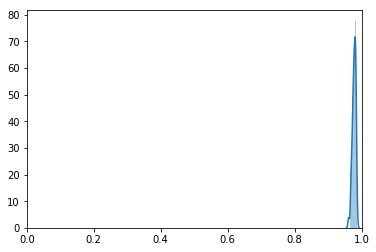

In [24]:
yup = []
desc = wl.tokenize(wl.df.sample(n=1).description.values[0])
last_vec = wl.model.infer_vector(desc)
for n in range(0,100):
    v1 = wl.model.infer_vector(desc)
    yup.append(1-cosine(v1,last_vec))
    last_vec = v1

sns.distplot(yup)
plt.xlim([0,1])

In [102]:
desc

array([ 0.57075334,  0.027789  ,  0.17891222, -0.06495365,  0.10074091,
        0.37965974, -0.40128413,  0.29022512, -0.20098117, -0.2077579 ,
        0.05115177,  0.22112073,  0.3728385 ,  0.28249887, -0.06018544,
       -0.6189052 ,  0.17734525, -0.34650815, -0.20069802,  0.11942659,
       -0.3169767 ,  0.2646895 ,  0.02555979, -0.00639584,  0.257845  ,
        0.26661906,  0.0749202 ,  0.1723073 , -0.14241464, -0.12358898,
       -0.70750266,  0.26103425, -0.15701754,  0.44066992,  0.21711776,
       -0.02261038,  0.22941981,  0.06658842, -0.45726934, -0.47532016],
      dtype=float32)

In [59]:
desc1 = [x.words for x in wl.tagged_data if x.tags[0]==d1]
desc1 = desc1[0]
desc1

['lightly',
 'fined',
 'unfiltered',
 'slightly',
 'cloudy',
 'appearance',
 'notes',
 'mineral',
 'citrus',
 'herbs',
 'spice',
 'aged',
 'partly',
 'neutral',
 'oak',
 'rest',
 'stainless',
 'steel',
 'flavors',
 'light',
 'creamy',
 'midpalate',
 'tart',
 'electric',
 'acids',
 'verge',
 'sour',
 'pair',
 'shellfish',
 'see',
 'best']

In [152]:
wl.model.most_similar('earthy',topn=5)

[('mossy', 0.8551816344261169),
 ('foresty', 0.7970216274261475),
 ('loamy', 0.7784765958786011),
 ('rooty', 0.7582866549491882),
 ('compost', 0.7577232122421265)]

In [139]:

for row in wl.df[wl.df.title.str.contains("Torrontés",case=False) & wl.df.title.str.contains("Alamos",case=False)].itertuples():
    print(row.description)

With attractive melon and other tropical aromas, this is a Torrontés that rises above the masses. It smells great and tastes like a pure blend of lychee fruit, tangerine and honeydew melon. The palate feel is smooth and round, and the finish is dry, clean and healthy. It's everything that Torrontés should be. Drink now.
Chunky and a bit dull smelling, with apple, melon and peach aromas. Papaya and green melon flavors seem to be flattening with age, and the finish is long but nondescript. Drink now or wait for the '09. Imported by Alamos USA.
A highly perfumed nose offers potent aromas of bath soap and lychee. The palate is chunky but kept on par by lively acidity. Lychee, melon and lemon flavors finish sweet yet briny. Drink now.
This is fragrant and varietally-correct on the nose. Quince, lemon-lime and lychee flavors show their best right away before turning decidedly sweet on the finish.
Chunky and a bit dull smelling, with apple, melon and peach aromas. Papaya and green melon flavo

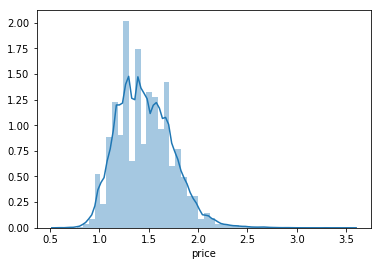

In [40]:
sns.distplot(np.log10(wl.df.price))


In [13]:
len(wines)


0

In [49]:
wl.column_cnt


{'country': None,
 'description': None,
 'points': None,
 'price': None,
 'region_1': [{'count': 2, 'name': 'Bianco di Custoza'},
  {'count': 1, 'name': 'San Martino della Battaglia'},
  {'count': 2, 'name': 'Alpine Valleys'},
  {'count': 8, 'name': 'Vin de Pays de la Méditerranée'},
  {'count': 1, 'name': 'Catalanesca del Monte Somma'},
  {'count': 43, 'name': 'Vosne-Romanée'},
  {'count': 1, 'name': 'McLaren Vale-Langhorne Creek'},
  {'count': 8, 'name': 'Cirò'},
  {'count': 2, 'name': 'Mâcon-Péronne'},
  {'count': 3, 'name': 'Monreale'},
  {'count': 11, 'name': 'Premieres Côtes de Bordeaux'},
  {'count': 73, 'name': 'San Juan'},
  {'count': 971, 'name': 'Santa Barbara County'},
  {'count': 1, 'name': 'Geographe'},
  {'count': 71, 'name': 'Maremma'},
  {'count': 38, 'name': 'Juliénas'},
  {'count': 7, 'name': 'Controguerra'},
  {'count': 2, 'name': 'Valtènesi'},
  {'count': 150, 'name': 'Beaune'},
  {'count': 14, 'name': 'Asti'},
  {'count': 27, 'name': 'Beaujolais Blanc'},
  {'count